In [ ]:
import vk
import vk_api
import request
import pandas as pd
import requests
import networkx as nx # библиотека для построения графа
import time
import urllib.request
import json
from tqdm import tqdm_notebook
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Для того, чтобы авторизоваться в API, нам нужно создать десктопное приложение ВКонтакте, с помощью которого необходимо получить уникальный **access token** и **app_id**. Как это можно провернуть без огромной потери времени, подробно описано [вот здесь](http://all-for-vkontakte.ru/catalog/access-token-vkontakte).

In [7]:
token= 'access_token'
user_id = 'user_id страницы пользователя'

In [8]:
# авторизация
session = vk.AuthSession(app_id='app_id', user_login='your_login', user_password='your_password')
api = vk.API(session, v='5.62')

Следующая команда запускает спаршенные данные, заблаговременно залитые на диск.

Если ты уже выполнял этот скрипт, достаточно просто подгрузить данные, потому что парсинг выполняется долго. Если же ты здесь в первый раз, смело запускай парсинг и иди попей чаю :)

In [9]:
import pickle
with open('friends_graph.pkl', 'rb') as f:
    user_ids, nf, totalf = pickle.load(f)

## Парсим данные

In [367]:
# парсинг id друзей
users = json.loads(urllib.request.urlopen('https://api.vk.com/method/friends.get?user_id='+user_id
                               +'&access_token='+token
                                          + "&v=5.74"
                              ).read().decode('utf-8'))
user_ids = users['response']['items']

In [368]:
# парсим друзей друзей
nf = []
totalf = []

for u in tqdm_notebook(user_ids):
    _friends = json.loads(urllib.request.urlopen('https://api.vk.com/method/friends.get?user_id='+str(u)
                                             +'&fields=name,photo&access_token='+token+"&v=5.74").read().decode('utf-8'))
    fl = _friends.get('response', {}).get('items', [])
    n = len(fl)
    print(n, end=' ')
    nf.append(n)
    totalf.append(fl)
    time.sleep(0.5) # ставим паузу, потому что VK ограничивает число запросов в секунду.

330 180 2272 758 1140 335 474 471 704 257 2294 610 3269 193 5000 375 1789 1699 160 5000 220 625 544 375 281 238 184 3271 1965 30 167 440 331 484 244 235 738 2078 91 555 1030 285 631 425 432 3381 218 731 1348 601 669 3295 228 2373 208 335 5000 220 506 92 216 671 643 1176 2002 180 90 490 88 321 273 195 660 630 153 207 81 606 178 358 142 379 398 451 348 607 1818 360 461 331 507 343 333 610 128 2815 432 1005 695 215 782 585 335 492 484 77 584 462 383 405 1152 459 69 925 99 270 2 647 101 892 294 247 1226 750 358 285 437 561 757 130 936 253 1050 645 105 147 412 0 449 1656 171 72 246 3172 589 316 552 180 210 1449 254 476 0 85 312 214 1168 295 299 250 283 459 55 497 300 349 686 3849 0 428 546 100 254 501 227 144 183 308 407 256 315 415 660 217 431 226 155 797 239 241 290 832 329 154 425 156 311 0 84 86 165 173 301 657 702 334 216 714 270 169 162 319 2084 255 196 937 463 322 942 370 671 116 305 564 460 216 802 318 157 373 347 746 150 134 520 39 153 258 72 167 711 2344 226 75 89 776 239 349 532 

Запишем это на диск, чтобы в следующий раз не запускать:

In [369]:
import pickle
with open('friends_graph.pkl', 'wb') as f:
    pickle.dump([user_ids, nf, totalf], f)

## Рисуем социальные граф

In [10]:
G = nx.Graph()
G.add_nodes_from(user_ids)
G.add_edges_from([(uid1, friend['id']) 
                  for uid1, list_of_friends in zip(user_ids, totalf) 
                  for friend in list_of_friends if friend['id'] in user_ids])

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


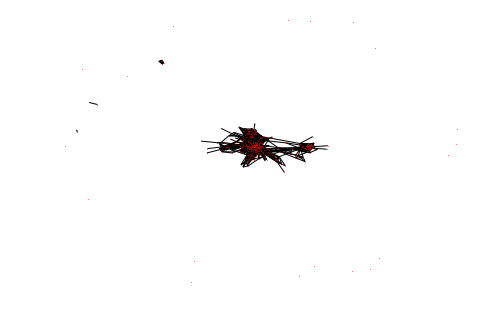

In [12]:
# неинформативный граф (готовое решение пакета)
nx.draw(G, node_size  = 0.1)

In [14]:
# размер графа
print(G.number_of_nodes(), G.number_of_edges())

379 3472


In [15]:
# связный ли граф?
nx.is_connected(G)

False

In [16]:
#число соединений в графе
subgraphs = [sg for sg in nx.connected_component_subgraphs(G)]
print(len(subgraphs))

comp_lengths = [len(sg.nodes()) for sg in subgraphs]
print(comp_lengths)

23
[351, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]


In [18]:
# Выведем друзей, у которых есть связи между собой
names = {}
for uid1, list_of_friends in zip(user_ids, totalf):
    for friend in list_of_friends:
        if friend['id'] in user_ids:
            names[friend['id']] = friend['first_name'] + ' ' + friend['last_name']

In [19]:
G1 = subgraphs[np.argmax(comp_lengths)]
labeldict = {uid:names.get(uid, '') if G1.degree(uid) > 25 else '' for uid in list(G1.nodes)}

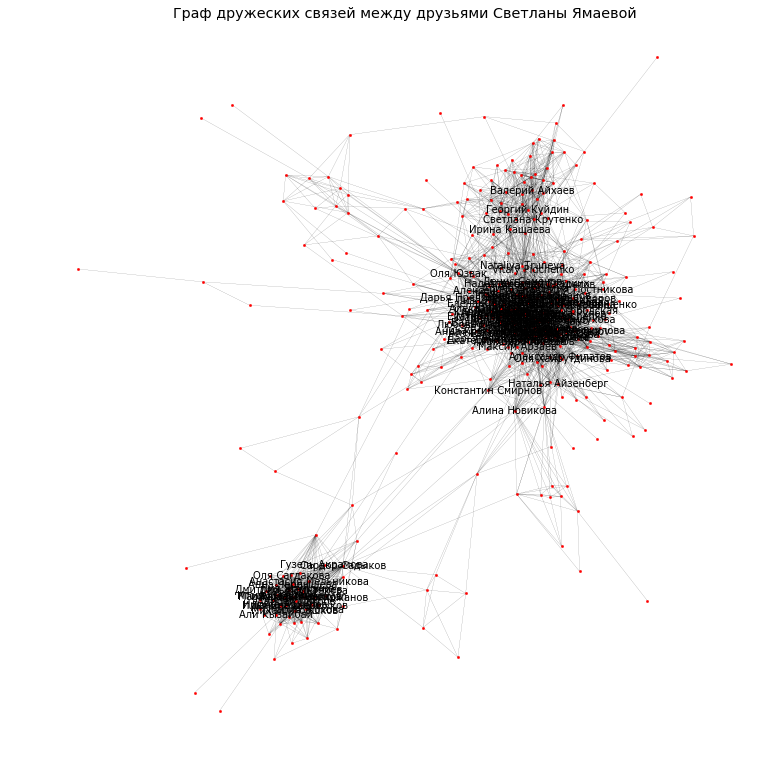

In [21]:
G1 = subgraphs[np.argmax(comp_lengths)]
plt.figure(figsize = (10, 10))
nx.draw_spring(G1, node_size = 5, width=0.1, labels=labeldict, with_labels = True, font_size=10, font_family  = 'Verdana')
plt.title('Граф дружеских связей между друзьями Светланы Ямаевой');

Как видим, образовалось два явных кластера: центральный -- это круг общения из Иркутска, где мои друзья так же активно поддарживают отношения друг с другом, отсюда и такая концентрированность. 

Сегмент чуть поменьше, располагающийся внизу, содержит в себе моих друзей и знакомых из Москвы -- в основном. это ребята из Вышки, которые тоже между собой хорошо знакомы. 

Третий сегмент размерами поскромнее, чуть повыше центрального -- это ребята из лицея и одноклассники: тоже специфическая группа, в которой свои общаются со своими (круг общения из лицея преимущественно и остается чисто лицейским, не переходящим, к примеру, в универский).

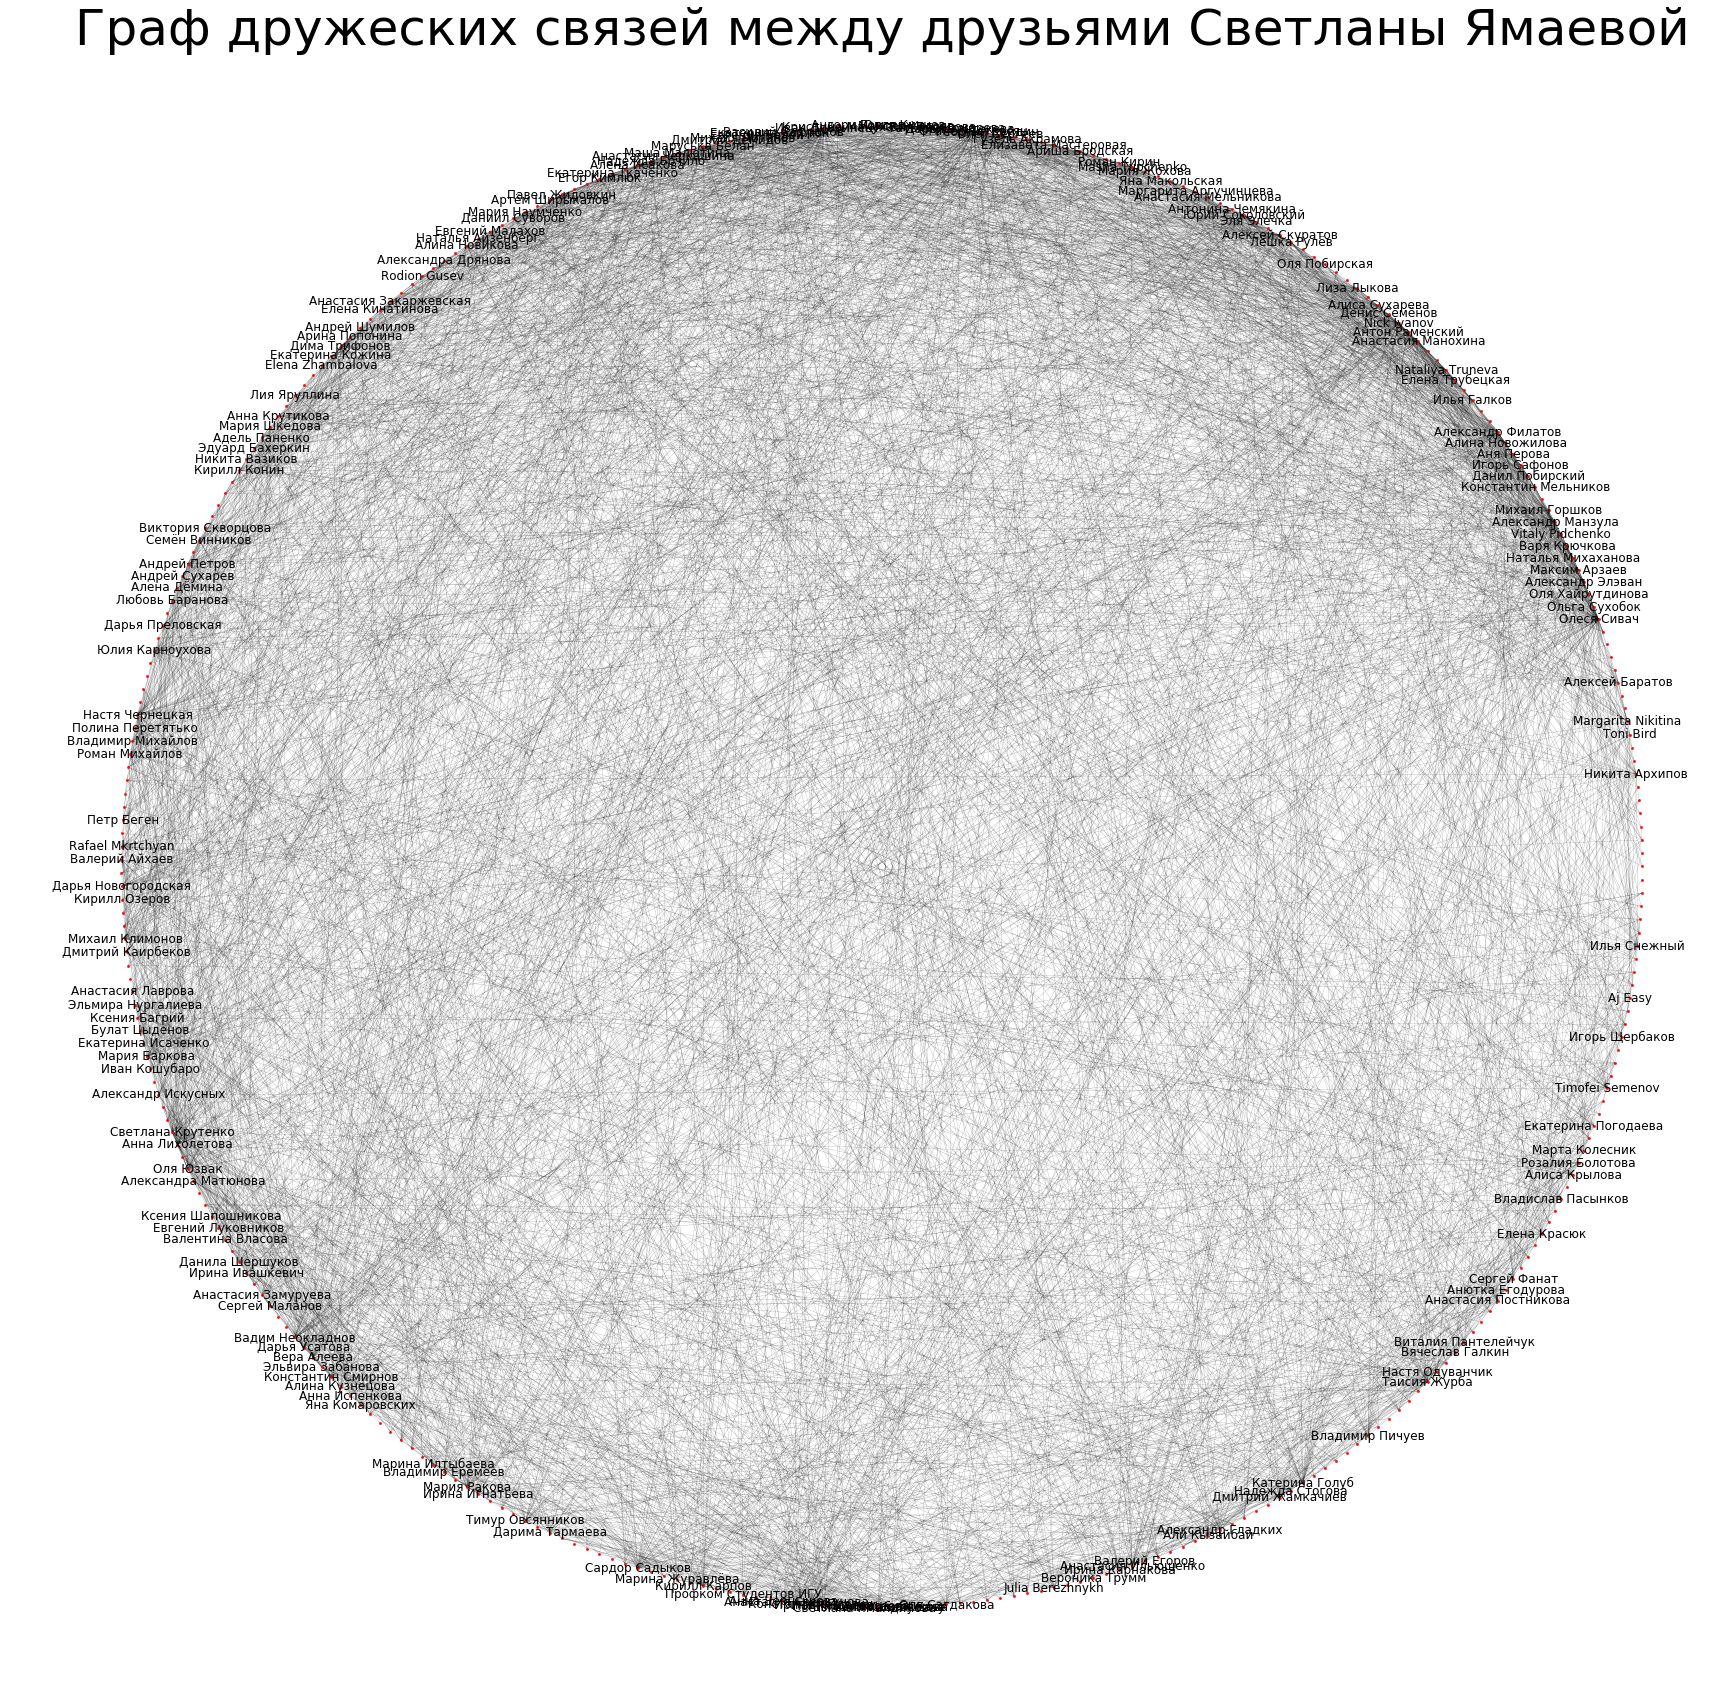

In [23]:
# другая форма визуализации с использованием концентрических окружностей

labeldict = {uid:names.get(uid, '') if G1.degree(uid) > 15 else '' for uid in list(G1.nodes)}

plt.figure(figsize = (30,30))
plt.title('Граф дружеских связей между друзьями Светланы Ямаевой', fontsize = 50)
nx.draw_shell(G1, node_size = 5, width  = 0.1, labels=labeldict, with_labels = True)

На данной визуализации выведены имена тех друзей вк, с которыми я имею по крайней мере 15 общих друзей.

## Анализ полученных данных

В числе параметров к графику, напоминающему клубок пряжи, есть такой, как степень широты дружеских связей (**nx.degree**, иначе говоря -- коэффициент, по которому список дрзей ранжируется от того, с кем у меня наибольшее количество друзей, к тому френду, с которым у меня нет общих связей ВК. 

На основе этого можно вывести топ-10 друзей по количеству общих:

In [347]:
di = nx.degree_centrality(G1)
for uid in sorted(di, key=di.get, reverse=True)[:10]:
    print('{:30} has degree centrality {}'.format(names[uid], di[uid]))

Иван Добринец                  has degree centrality 0.31142857142857144
Олеся Сивач                    has degree centrality 0.26285714285714284
Оганес Петросян                has degree centrality 0.26285714285714284
Nick Ivanov                    has degree centrality 0.23142857142857143
Юрий Соколовский               has degree centrality 0.21428571428571427
Олег Сергеев                   has degree centrality 0.21142857142857144
Маруська Белан                 has degree centrality 0.19714285714285715
Александр Филатов              has degree centrality 0.18857142857142858
Василий Сафронов               has degree centrality 0.18857142857142858
Александр Манзула              has degree centrality 0.18571428571428572


На самом деле, с Ваней у меня целых 109 общих друга :)

## Посмотрим, как распределены друзья друзей

In [28]:
# закинем число друзей вообще моих друзей в ряд и выведем описательные статистики (без учета удаленных аккаунтов)
nf_vec = pd.Series(nf)
nf_vec = nf_vec[nf_vec>0]
nf_vec.describe()

count     363.000000
mean      553.809917
std       774.414582
min         2.000000
25%       179.000000
50%       312.000000
75%       584.500000
max      5000.000000
dtype: float64

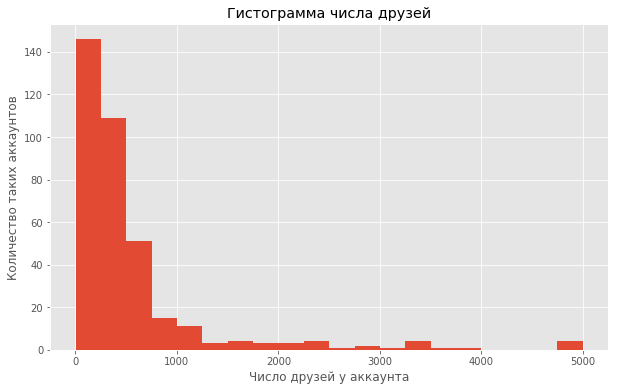

In [29]:
nf_vec.hist(bins=20, figsize=(10,6))
plt.title('Гистограмма числа друзей')
plt.xlabel('Число друзей у аккаунта')
plt.ylabel('Количество таких аккаунтов');

Как видим, налицо логнормальное распределение, характерное для таких явлений, как исследование френд листа, анализа подписчиков. Проще говоря, есть не такое большое количество друзей, имеющих в своем френд-листе хреналлиард друзей, которые перетягивают на себя существенную долю общего числа друзей моих друзей. А на остальных моих друзей, значительная доля которых имеют не такое большое количество друзей, приходится малая доля.

Логарифмируем, чтобы получить график нормального распределения:

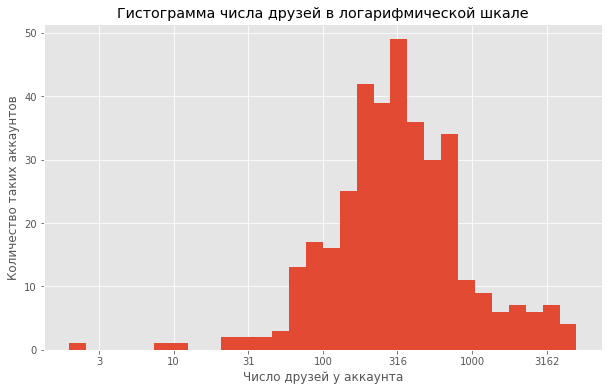

In [30]:
h = np.log10(nf_vec).hist(bins=30, figsize=(10,6))
a = (10 ** h.get_xticks()).astype(int)
h.set_xticklabels(a)
plt.title('Гистограмма числа друзей в логарифмической шкале')
plt.xlabel('Число друзей у аккаунта')
plt.ylabel('Количество таких аккаунтов');

Для того, чтобы еще проиллюстрировать ситуацию с неравномерностью распределения общего числа друзей всех моих друзей ВКонтакте, построим [кривую Лоренца](https://en.wikipedia.org/wiki/Lorenz_curve). 

Оказалось, что классическая формулировка закона Парето (20% семей обладают 80% дохода) в нашем случае чуть мягче: первые 20% друзей набрали только 60% дружеских связей.

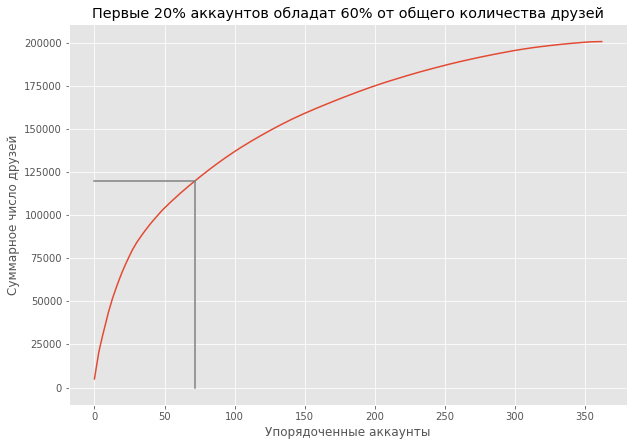

In [32]:
cumsum = nf_vec.sort_values(ascending=False).cumsum().reset_index(drop=True)
plt.figure(figsize=(10,7))
cumsum.plot()
p20 = int(len(cumsum)*0.2)
s20 = cumsum.iloc[p20]
plt.plot([p20, p20], [0, s20], c='gray');
plt.plot([0, p20], [s20, s20], c='gray');
plt.title('Первые {:.0%} аккаунтов обладат {:.0%} от общего количества друзей'.format(0.2, s20/sum(nf_vec)))
plt.xlabel('Упорядоченные аккаунты')
plt.ylabel('Суммарное число друзей');